Contexto: Um drone de inspeção voa dentro de um galpão industrial para coletar dados.
O objetivo é maximizar a coleta de dados sem bater nem gastar energia demais.

Estados: $S={(i,j)∣i,j∈{0,1,2}}$

Onde: (2,2) é ponto de coleta de dados (estado terminal) e (1,1) é área turbulenta (movimento incerto)

Ações: Em cada estado não terminal, o drone pode escolher entre cima, baixo, esq ou dir

Ambiente:

**Movimento normal**

Se o drone estiver fora da área turbulenta (1,1):
80% vai para o estado desejado
20% fica parado

**Área turbulenta (1,1)**

40% vai para o estado desejado
30% vai para um estado aleatório adjacente
30% fica parado

Se a ação levar para fora da grade, permanece no mesmo estado.

Recompensas:

Cada movimento	−1

Entrar em (1,1)	−3

Chegar em (2,2)	+20

Bater na parede	−2

In [26]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
N_ESTADOS = 9
ESTADO_TERMINAL = 8
ESTADO_TURBULENTO = 4
GAMMA = 0.9

acoes = ['U', 'D', 'L', 'R']

# mapeia estados -> coordenadas
estados = {
    0: (0, 0),
    1: (0, 1),
    2: (0, 2),
    3: (1, 0),
    4: (1, 1),
    5: (1, 2),
    6: (2, 0),
    7: (2, 1),
    8: (2, 2)
}

# mapeia coordenadas -> estados
coordenadas = {v: k for k, v in estados.items()}

# definindo uma política qualquer
policy = {i: 'U' for i in range(N_ESTADOS)}

# inicializando função valor
V = {i: 0.0 for i in range(N_ESTADOS)}

In [8]:
def movimento(s, acao):
  i, j = estados[s]

  if acao == 'U':
    i -= 1
  elif acao == 'D':
    i += 1
  elif acao == 'L':
    j -= 1
  elif acao == 'R':
    j += 1

  # se bateu na parede
  if (i, j) not in coordenadas:
    return s, -2

  return coordenadas[(i, j)], -1

# transicao() retorna 'probabilidade, estado futuro e reward' em todos os casos
def transicao(s, acao):
  resultados = []

  s_desejado, reward_desejado = movimento(s, acao)

  def recompensa (prox_s, r_base):
    if prox_s == ESTADO_TURBULENTO:
      return r_base - 3
    elif prox_s == ESTADO_TERMINAL:
      return r_base + 20
    else:
      return r_base

# se é estado turbulento
  if s == 4:
    r_final = recompensa(s_desejado, reward_desejado)
    resultados.append((0.4, s_desejado, r_final))  # 40% de chance de ir pro lugar desejado

    # 30% de chance de ir para um vizinho adjacente
    vizinhos = []

    for a in acoes:
      s_n, reward_n = movimento(s, a)
      reward_n = recompensa(s_n, reward_n)
      vizinhos.append((s_n, reward_n))

    prob_cada_vizinho = 0.3 / len(vizinhos)

    for s_vizinho, reward_vizinho in vizinhos:
      resultados.append((prob_cada_vizinho, s_n, reward_n))

    # 30% ficar parado
    resultados.append((0.3, s, -1))

# caso normal (estado nao turbulento)
  else:
    r_final = recompensa(s_desejado, reward_desejado)
    resultados.append((0.8, s_desejado, r_final))
    resultados.append((0.2, s, -1))

  return resultados

In [16]:
# aplicando policy iteration

def policy_evaluation(V, policy):
  while True:
    delta = 0
    for s in range(N_ESTADOS):
      if s == ESTADO_TERMINAL:
        continue

      V_antigo = V[s]
      acao = policy[s]

      V_novo = 0
      for prob, s_futuro, reward in transicao(s, acao):
        V_novo += prob * (reward + GAMMA * V[s_futuro])

      V[s] = V_novo

      delta = max(delta, abs(V_antigo - V[s]))

    if delta < 1e-4:
      break


def policy_improvement(V, policy):
  policy_stable = True

  for s in range(N_ESTADOS):
    acao_antiga = policy[s]

    acao_valor = {}

    for a in acoes:
      q = 0
      for prob, s_futuro, reward in transicao(s, a):
          q += prob * (reward + GAMMA * V[s_futuro])

      acao_valor[a] = q

    policy[s] = max(acao_valor, key=acao_valor.get)

    if acao_antiga != policy[s]:
      policy_stable = False

  return policy_stable

In [17]:
while True:
  policy_evaluation(V, policy)
  stable = policy_improvement(V, policy)

  if stable:
    break

In [18]:
policy

{0: 'D', 1: 'R', 2: 'D', 3: 'D', 4: 'D', 5: 'D', 6: 'R', 7: 'R', 8: 'D'}

In [19]:
V

{0: 93.55668154525445,
 1: 107.93955398209533,
 2: 124.32004759071968,
 3: 107.93955398209533,
 4: 122.02004677581009,
 5: 142.9756097560974,
 6: 124.32004759071968,
 7: 142.9756097560974,
 8: 141.99999999999983}

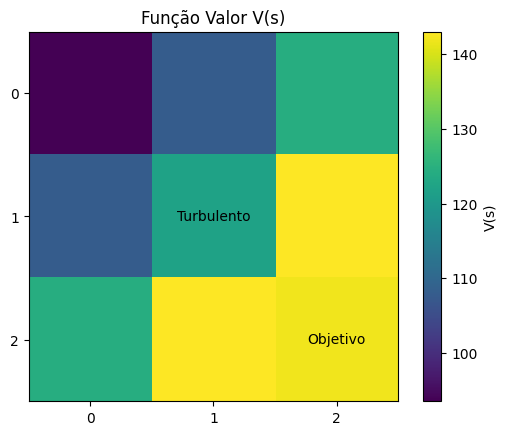

In [43]:
# Converter V em matriz 3x3
V_grid = np.zeros((3,3))
for s, (i,j) in estados.items():
    V_grid[i, j] = V[s]

plt.figure()
plt.imshow(V_grid)
plt.colorbar(label="V(s)")
plt.title("Função Valor V(s)")
plt.xticks([0,1,2])
plt.yticks([0,1,2])

# marcar turbulência e objetivo
plt.text(1,1,"Turbulento",ha='center',va='center')
plt.text(2,2,"Objetivo",ha='center',va='center')

plt.show()

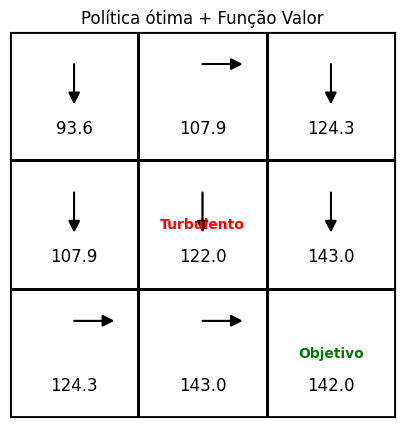

In [45]:
fig, ax = plt.subplots(figsize=(5, 5))

# desenhar o grid
for i in range(3):
    for j in range(3):
        rect = plt.Rectangle((j, i), 1, 1, fill=False, linewidth=2)
        ax.add_patch(rect)

# definição das setas (deslocamento absoluto)
setas = {
    'U': (0, -0.3),
    'D': (0, 0.3),
    'L': (-0.3, 0),
    'R': (0.3, 0)
}

# desenhar política e valores
for s, a in policy.items():
    i, j = estados[s]
    x_center = j + 0.5
    y_center = i + 0.5

    ax.text(x_center, y_center + 0.25, f"{V[s]:.1f}", ha='center', va='center', fontsize=12)

    if s != ESTADO_TERMINAL:
        dx, dy = setas[a]
        y_start = y_center - 0.25
        x_start = x_center

        ax.arrow(
            x_start, y_start,
            dx, dy,
            head_width=0.08,
            head_length=0.08,
            length_includes_head=True,
            color='black',
            linewidth=1.2
        )

# marcar estados especiais
ax.text(1.5, 1.5, "Turbulento", ha='center', va='center', fontsize=10, color='red', weight='bold')
ax.text(2.5, 2.5, "Objetivo", ha='center', va='center', fontsize=10, color='green', weight='bold')

ax.set_xlim(0, 3)
ax.set_ylim(3, 0)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Política ótima + Função Valor")
plt.gca().set_aspect('equal')

plt.show()

Como esperado, as setas seguem um sentido afim de evitar o centro (área turbulenta). Além disso, os valores da Função Valor aumentam conforme se aproxima do objetivo final.